# <span style='color:SteelBlue'>Step 1 : POC extration de texte</span>

# <span style='background:blue'>Introduction</span>

Ce notebook présente une preuve de concept (POC) pour tester différentes méthodes d'OCR (reconnaissance optique de caractères) sur des images. L'objectif est d'extraire le texte des images afin de l'utiliser pour renommer les fichiers et les organiser dans un répertoire spécifique.
___

**Source des datasets**<br>
Source : Entreprise Rpur<br>

Le dataset est un ensemble d'images.

# <span style='background:grey'>Importations des librairies</span>

In [1]:
# General imports
import time
import sys
from datetime import datetime
import os

# Image processing libraries
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image

# OCR libraries
import pytesseract
from pytesseract import Output
import easyocr

# Display settings
%matplotlib inline

# Versions
print("Interpréteur python :")
print("Python        : " + sys.version + "\n")

print("Version des librairies utilisées :")
print("Easyocr       : " + easyocr.__version__)
print("Matplotlib    : " + mpl.__version__)
print("OpenCV        : " + cv2.__version__)
print("Pytesseract   : " + pytesseract.__version__)

# Print time
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

Interpréteur python :
Python        : 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]

Version des librairies utilisées :
Easyocr       : 1.7.2
Matplotlib    : 3.10.1
OpenCV        : 4.11.0
Pytesseract   : 0.3.13

Code lance le : 2025-04-02T22:10:00.851469


# <span style='background:blue'>I. Pytesseract</span>

## <span style='background:green'>1/ Test initial</span>

Fonction qui lit le texte de l'image

In [2]:
def image_to_text(input_path):
    """
    A function to read text from images.
    """
    img = cv2.imread(input_path)
    text = pytesseract.image_to_string(img)

    return text.strip()

Fonction qui affiche l'image

In [3]:
def display_image(image, title="Image"):
    """
    A function to display an image using cv2 and matplotlib.
    """
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

On trouve une image

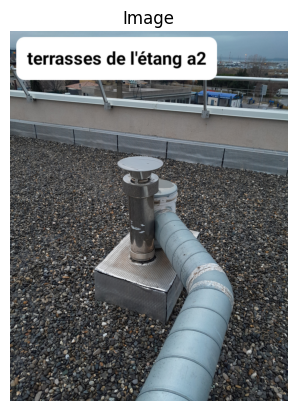

Extracted text:



In [4]:
# Define image path
image_test_path = "../data/test/test_pierre.jpg"
display_image(cv2.imread(image_test_path))

# Extract text
extracted_text = image_to_text(image_test_path)
print("Extracted text:")
print(extracted_text)

Ca ne marche pas. Il ne trouve pas de texte dans l'image.

## <span style='background:green'>2/ Dessiner des cadres autour du texte</span>

Une opération courante de l'OCR consiste à tracer des boîtes de délimitation autour du texte. Cette opération est prise en charge par PyTesseract.

Tout d'abord, nous transmettons une image chargée à la fonction image_to_data apres l'avoir convertit avec PIL en RGB.

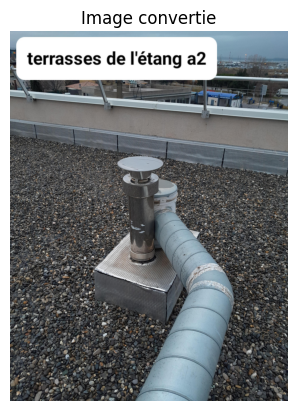

In [5]:
# Define image path for testing
image_test_converted_path = "../data/test/test_pierre_converted.jpg"

try:
    with Image.open(image_test_path) as img:
        img.save(image_test_converted_path)
except Exception as e:
    print(f"Erreur lors de l'ouverture de l'image : {e}")

# Charger l'image convertie avec OpenCV
image = cv2.imread(image_test_converted_path)
display_image(cv2.imread(image_test_converted_path), title="Image convertie")

# Vérifier si l'image a été chargée correctement
if image is None:
    print("Erreur : Impossible de charger l'image")

Conversion de l'image en data frame

In [6]:
# Extract recognized data from easy text
data = pytesseract.image_to_data(
    image_test_converted_path,
    output_type=Output.DICT
)

data

{'level': [1, 2, 3, 4, 5],
 'page_num': [1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1],
 'par_num': [0, 0, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1],
 'word_num': [0, 0, 0, 0, 1],
 'left': [0, 0, 0, 0, 0],
 'top': [0, 0, 0, 0, 0],
 'width': [3072, 3072, 3072, 3072, 3072],
 'height': [4096, 4096, 4096, 4096, 4096],
 'conf': [-1, -1, -1, -1, 95],
 'text': ['', '', '', '', '']}

Le dictionnaire contient de nombreuses informations sur l'image. Remarquez tout d'abord les touches conf et text. Ils ont tous deux une longueur de 5 :

In [7]:
n_boxes = len(data["text"])
print(f"Nombre de boîtes : {n_boxes}")

Nombre de boîtes : 5


Cela signifie que pytesseract a tiré 5 boîtes.

À l'aide de ces informations, dessinons les boîtes sur l'image dans OpenCV.

Tout d'abord, nous extrayons à nouveau les données et leur longueur :

In [8]:
def draw_boxes_on_image(image_path, data, n_boxes):
    """
    A function to draw boxes on the image based on the recognized text.
    """
    # Load the image
    image = cv2.imread(image_path)

    # Loop through each box
    for i in range(n_boxes):
        
        # Coordinates
        x, y = int(data["left"][i]), int(data["top"][i])
        w, h = int(data["width"][i]), int(data["height"][i])

        # Corners
        top_left = (x, y)
        bottom_right = (x + w, y + h)

        # Box params
        green = (0, 255, 0)
        thickness = 3  # pixels

        # Draw rectangle
        cv2.rectangle(
            img=image,
            pt1=top_left,
            pt2=bottom_right,
            color=green,
            thickness=thickness
        )

    # Display the image with rectangles
    display_image(image, title="Image avec rectangles")


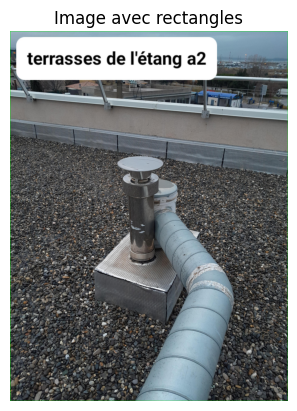

In [9]:
draw_boxes_on_image(image_test_converted_path, data, n_boxes)

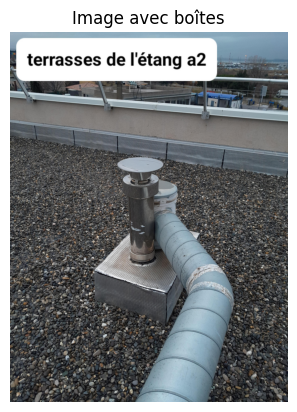

In [10]:
# Save the image
output_image_path = "../data/test/test_pierre_with_box.jpg"
cv2.imwrite(output_image_path, image)

display_image(cv2.imread(output_image_path), title="Image avec boîtes")

Le test n'est pas concluant car la totalité de l'image est considérée comme une seule boîte.

## <span style='background:green'>3/ Tester differentes config de pretraitement</span>


Fonction qui applique un prétraitement à l'image avant de l'envoyer à pytesseract.


Le prétraitement consiste à convertir l'image en niveaux de gris, à appliquer un flou gaussien et à effectuer une opération de seuillage.

In [11]:
def preprocess_image(image_path):
    """
    A function to preprocess the image for better OCR results.
    """
    # Load the image
    image = cv2.imread(image_path)
    display_image(image, "Image originale")

    # Resize the image
    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    gray = cv2.bilateralFilter(gray, 9, 75, 75)

    # Egalization of histogram
    gray = cv2.equalizeHist(gray)

    # Apply adaptive thresholding
    gray = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    display_image(gray, "Image prétraitée")
    return gray

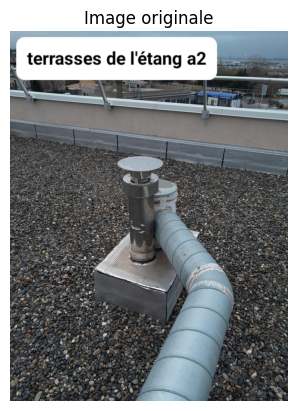

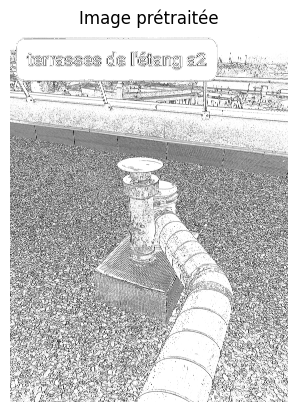

Nombre de boîtes : 103


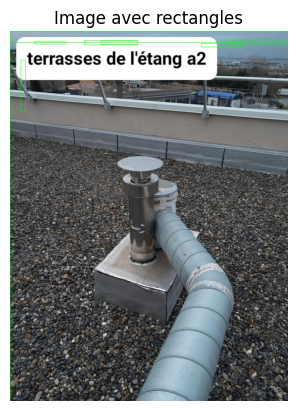

In [12]:
# Preprocess the image
preprocessed_image = preprocess_image(image_test_converted_path)

# Extract recognized data from easy text
data = pytesseract.image_to_data(
    preprocessed_image,
    output_type=Output.DICT
)

# Number of boxes
n_boxes = len(data["text"])
print(f"Nombre de boîtes : {n_boxes}")

draw_boxes_on_image(image_test_converted_path, data, n_boxes)

La localisation des box n'est pas de bonne augure. Nous testons d'extraire le texte malgré tout.

Fonction pour extraire le texte de l'image prétraitée.

In [13]:
def extract_text_tesseract(image, psm=3, oem=3):
    """
    A function to extract text from an image using Tesseract OCR.
    """
    config = f'--psm {psm} --oem {oem} -l fra'
    text = pytesseract.image_to_string(image, config=config)
    return text

In [14]:
# Extract text using Tesseract
text_tesseract = extract_text_tesseract(preprocessed_image)
print("Texte extrait par Tesseract :")
print(text_tesseract)

Texte extrait par Tesseract :
PR: tre re

D mn are

hrs
Ets
ne

FC

VAE Enr

ns ”

d

ë

fa
LA)
4!

ñ

u

44




Le texte extrait ne correspond pas à l'image. Il y a trop de bruit dans l'image.

<div class="alert alert-block alert-success"><b>Pytesseract </b>

La librairie Pytesseract ne permet pas d'extraire le texte de l'image. Il est donc impossible de renommer les fichiers.</div>

# <span style='background:blue'>II. EasyOCR</span>


Nous installons la librairie easyOCR avec pip en démarrant VSC en mode admin.

Fonction qui lit le texte de l'image avec easyOCR

In [15]:
def extract_text_easyocr(image_path):
    """
    A function to extract text from an image using EasyOCR.
    """
    reader = easyocr.Reader(['fr'])
    text = reader.readtext(image_path, detail=0)
    return " ".join(text)

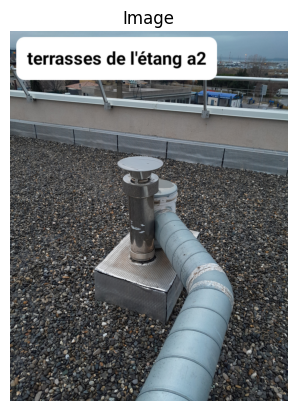

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



Texte extrait par EasyOCR :
terrasses de l'étang a2


In [16]:
# Display the image
display_image(cv2.imread(image_test_path))

# Extract text using EasyOCR
text_easyocr = extract_text_easyocr(image_test_converted_path)
print("\nTexte extrait par EasyOCR :")
print(text_easyocr)

<div class="alert alert-block alert-success"><b>EasyOCR </b>

La librairie EasyOCR permet d'extraire le texte de l'image. Il est donc possible de renommer les fichiers.</div>

# <span style='background:blue'>III. Mistral OCR</span>

Pour tester Mistral OCR, nous devons d'abord spécifier une clé d'API.

In [20]:
# Vérifier la clé API Mistral
api_key = os.environ.get("MISTRAL_API_KEY")

if not api_key:
    print("Erreur : La clé API Mistral n'est pas définie.")

Erreur : La clé API Mistral n'est pas définie.


Nous vérifions que la clé d'API est valide.

In [21]:
print(os.environ.get("MISTRAL_API_KEY"))

None


Je dois avoir une clef API Mistral pour pouvoir utiliser le service OCR. Je n'ai pas de clef API Mistral, donc je ne peux pas tester le code.

<div class="alert alert-block alert-success"><b>MistralOCR </b>

La librairie MistralOCR est payante. Il est donc impossible de l'utiliser sans une clé d'API valide.</div>

# <span style='background:blue'>Conclusion</span>

Nous avons testé trois librairies d'OCR : Pytesseract, EasyOCR et Mistral OCR. Seule la librairie **EasyOCR** a permis d'extraire le texte de l'image.